### Packages loading

In [1]:
import sys
sys.path.insert(0, '..')
import numpy as np
import random
import qiskit
import qtm.evolution
import qtm.state
import qtm.qcompilation
import qtm.ansatz
import qtm.constant
from qtm.evolution import environment, mutate, selection, crossover, utils
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


## 1. Quantum architecture search for quantum state preparation problem

Now, we defind the problem which is need to solve

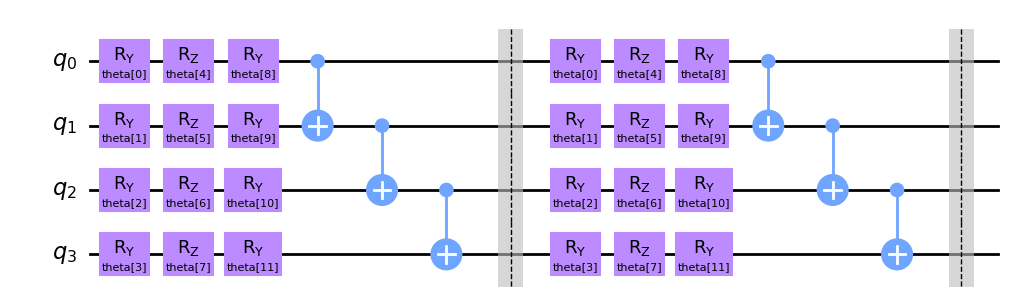

In [2]:
# n_qubits=4
# n=3
# theta = qiskit.circuit.ParameterVector('theta',n*n_qubits)
# #theta = np.random.rand(n*n_qubits)
# #print(theta)
# qc = qiskit.QuantumCircuit(n_qubits)
# #theta = [0,1,2]
# for j in range (2):
#     for i in range(n_qubits):
#         qc.ry(theta[i], i)
#     for i in range(n_qubits):
#         qc.rz(theta[i+n+1], i)
#     for i in range(n_qubits):
#         qc.ry(theta[i+2*(n+1)], i)
#     qc.cnot(0, 1)
#     qc.cnot(1, 2)
#     qc.cnot(2, 3)
#     qc.barrier()
# qc.draw('mpl')

In [2]:

print(qubit_op)

-0.7980464206492509 * IIII
+ 0.17771287465139923 * IIIZ
- 0.242742805131405 * IIZI
+ 0.17771287465139918 * IZII
- 0.24274280513140495 * ZIII
+ 0.1229330505618381 * IIZZ
+ 0.17059738328801052 * IZIZ
+ 0.044750144015351635 * YYYY
+ 0.044750144015351635 * XXYY
+ 0.044750144015351635 * YYXX
+ 0.044750144015351635 * XXXX
+ 0.16768319457718972 * ZIIZ
+ 0.16768319457718972 * IZZI
+ 0.17627640804319608 * ZIZI
+ 0.1229330505618381 * ZZII


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_49446/2063267724.py:16: DeprecationWarning: The QubitConverter class is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . Instead you should directly use the QubitMapper instance which you used to pass into the QubitConverter as the first argument. Refer to the documentation of the qiskit_nature.second_q.mappers module for more information.
  qubit_converter = QubitConverter(mapper)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/

In [2]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
estimator = Estimator()
def VQE_fitness(qc: qiskit.QuantumCircuit, num_iter = 10):
    from qiskit_nature.second_q.drivers import PySCFDriver
    from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, ParityMapper
    from qiskit_nature.units import DistanceUnit

    driver = PySCFDriver(
        atom="H 0 0 -0.35; H 0 0 0.35",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()
    hamiltonian = problem.hamiltonian.second_q_op()

    mapper=JordanWignerMapper()
    qubit_converter = QubitConverter(mapper)
    qubit_op = qubit_converter.convert(hamiltonian)
    vqe = VQE(estimator = estimator, ansatz = qc, optimizer=qiskit.algorithms.optimizers.SLSQP(maxiter=num_iter))
    return vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue.real

/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_60333/3041398680.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import VQE


Main algorithm, includes: init population, selection, crossover, mutate.

In [13]:
params = {'depth': 3,
          'num_circuit': 8,  # Must mod 8 = 0
          'num_generation': 40,
          'num_qubits': 4,
          'threshold': lambda eigenvalue: np.abs(eigenvalue - (-1.89215)) < 0.01,
          'prob_mutate': 0.01}

env = environment.EEnvironment(
    params,
    fitness_func = VQE_fitness,
    selection_func = selection.elitist_selection,
    crossover_func= crossover.onepoint_crossover,
    mutate_func=mutate.bitflip_mutate,
    pool = qtm.constant.operations
)

env.initialize_population()
env.evol() 

Step:  30%|███       | 12/40 [00:12<00:30,  1.10s/it]

AlgorithmError: 'The ansatz must be parameterized, but has no free parameters.'

Test best candidate again

In [11]:
qc = env.best_candidate.qc
print(VQE_fitness(qc, 100))

-1.8921568597287821


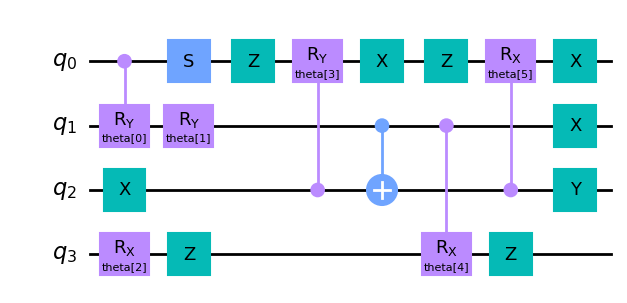

In [10]:
qc.draw('mpl')